In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp

In [2]:
# build matrices and graph
transition = np.array([
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 1/4, 0],
    [1/2, 0, 0, 1/3, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 1/3, 0, 1/3, 0]])

P = np.array([[lambda_ij/sum(node_i) for lambda_ij in node_i] for node_i in transition])
G = nx.DiGraph()
nodes_position_to_name = ['o', 'a', 'b', 'c', 'd']

for i, row in enumerate(transition):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i],nodes_position_to_name[j], transition=element)

for i, row in enumerate(P):
  for j, element in enumerate(row):
    if element != 0:
      G.add_edge(nodes_position_to_name[i],nodes_position_to_name[j], probability=element)

for i, node in enumerate(G.nodes()):
  G.add_node(node,omega=sum(transition[i,:]))

#Particle perspective

In [3]:
class Particle:
  # class attributes:
  arrived = False
  arrival_time = 0.0
  nodes_name_to_position = {'o':0, 'a':1, 'b':2, 'c':3, 'd':4}

  # class methods:
  def __init__(self, init_node):
    self.init_node = init_node
    self.node = init_node
    self.walk = [self.nodes_name_to_position[init_node]]
    self.walk_time = [0.0]

  def walk_to_node(self, node, time, return_check = False):
    self.node = node
    self.walk.append(self.nodes_name_to_position[node])
    self.walk_time.append(time)
    if return_check: # for point (a), need to check if particle has returned
      self.arrived = node == self.init_node # boolean expression

  def set_arrival_time(self, time):
    self.arrival_time = time


def ParticlesRandomWalk(G, particles, max_time=60):

  # iterate through all particles
  for particle in particles:
    time = 0

    # continue running until particle arrives to destination, or reaches simulation max time.
    while not particle.arrived and time < max_time:
      # simulate Poisson clock
      u = np.random.uniform(0,1,1)
      time += -1*np.log(u)/(G.nodes[particle.node]["omega"])

      # select node to move to
      probabilities = [G[particle.node][a]["probability"] for a in G.adj[particle.node]]
      x_next = np.random.choice(G.adj[particle.node], 1, p=probabilities)[0]

      # move particle
      particle.walk_to_node(x_next, float(time), return_check=True)

    # set return time inside the Particle object
    particle.set_arrival_time(time)
  return

In [4]:
# instantiate 100 particles:
num_particles = 100
particles = [Particle(init_node='b') for i in range(num_particles)]

# run all simulations
ParticlesRandomWalk(G, particles)

In [5]:
# results
print("Example of a simulated closed walk: ")
[print(f"node: {nodes_position_to_name[n]}, time: {t:7.2}", end="\n") for t, n in zip(particles[0].walk_time, particles[0].walk)]
print()

# average computation
average_return_time = np.mean([p.arrival_time for p in particles])
print(f"The average return time is: {average_return_time}")

Example of a simulated closed walk: 
node: b, time:     0.0
node: o, time:    0.32
node: a, time:     3.2
node: b, time:     3.6

The average return time is: 4.699335158051328


In [6]:
# more simulations to approximate better the average to the expected value.
num_particles = 100000
particles = [Particle(init_node='b') for i in range(num_particles)]

# run all simulations
ParticlesRandomWalk(G, particles)
average_return_time = np.mean([p.arrival_time for p in particles])
print(f"The average return time is: {average_return_time}")
# e.g.
# n_sim = some avg return times:
# 0.1 M = 4.6129, 4.5956, 4.5875
# 1.0 M = 4.5952

The average return time is: 4.598381351628264


#Node perspective

In [7]:
def NodeRandomWalk(G, max_time=60, num_particles = 100, global_frequency=1):
  nodes_info = {node:{"time":[0], "n":[int(G.nodes[node]['n_par'])]} for node in G.nodes()}
  time = 0

  while time < max_time:
    # simulate poisson clock
    u = np.random.uniform(0,1,1)
    time += -1*np.log(u)/(global_frequency*num_particles)

    # select node to move from given internal clock and number of particles in it
    node_probabilities = np.array([n_attr["n_par"]*n_attr["omega"] for node, n_attr in G.nodes().items()])
    node_probabilities /= sum(node_probabilities) # normalize to sum 1
    select_node = np.random.choice(G.nodes(), 1, p=node_probabilities)[0]

    # select next node for a particle to move to
    step_probabilities = [G[select_node][a]["probability_bar"] for a in G.adj[select_node]]
    next_node = np.random.choice(G.adj[select_node], 1, p=step_probabilities)[0]

    # move particle
    G.nodes[select_node]['n_par'] -= 1
    G.nodes[next_node]['n_par'] += 1

    # save info in time
    for node in G.nodes():
      nodes_info[node]["time"].append(time[0])
      nodes_info[node]["n"].append(int(G.nodes[node]["n_par"]))

  return nodes_info

In [8]:
# build matrices and graph to run with P_bar
H = G.copy()
global_frequency = max([sum(node_i) for node_i in transition])
P_bar = np.array([[lambda_ij/global_frequency for lambda_ij in node_i] for node_i in transition])
for i in range(P_bar.shape[0]): P_bar[i,i] = 1 - sum(P_bar[i])

for i, row in enumerate(P_bar):
  for j, element in enumerate(row):
    if element != 0:
      H.add_edge(nodes_position_to_name[i],nodes_position_to_name[j], probability_bar=element)

# initialize particle position for simulation
for i, node in enumerate(H.nodes()):
  if node=='o': H.add_node(node,n_par=100) # 100 particles in node 'o'
  else: H.add_node(node,n_par=0) # 0 particles in nodes 'a, b, c, d'

plot_info = NodeRandomWalk(H, 60)

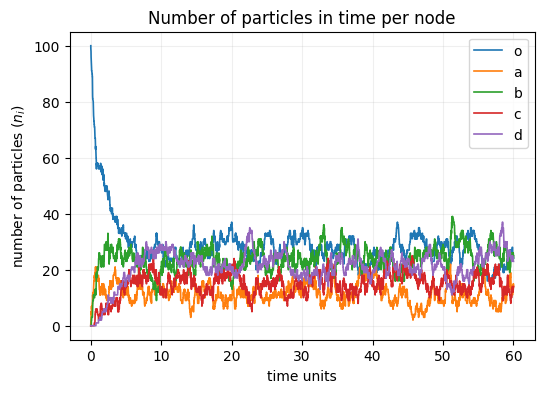

In [9]:
# plot results
fig, ax = plt.subplots(figsize=(6,4))
for node in H.nodes():
  plt.plot(plot_info[node]["time"],plot_info[node]["n"], label=node, linewidth=1.2)
plt.legend()
plt.title("Number of particles in time per node")
plt.xlabel("time units")
plt.ylabel("number of particles ($n_i$)")
plt.grid('minor', alpha=0.2)
# fig.savefig('ex2_node.svg', format='svg', dpi=1200)
plt.show()

In [10]:
# average number of particles in each node from time unit 10 on.
average_particles_per_node_conv = [np.mean(plot_info[node]["n"][len(plot_info[node]["n"])//5:]) for node in H.nodes()]
omega = transition @ np.ones((5,1))

[print(f"node: {n}, avg_particles: {average_particles_per_node_conv[i]:.3}, omega: {omega[i][0]:.2}") for i, n in enumerate(nodes_position_to_name)]
pass

node: o, avg_particles: 27.0, omega: 0.6
node: a, avg_particles: 11.3, omega: 1.0
node: b, avg_particles: 24.3, omega: 0.83
node: c, avg_particles: 15.4, omega: 1.0
node: d, avg_particles: 22.0, omega: 0.67
